In [283]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [284]:
def import_24bit_data(fn):
    table = pd.read_csv(fn, sep=',', skiprows = 0)
    table.columns = np.arange(0,422,1)
    
    data_ch0 = []
    for i in range(len(table[0])):
        for j in range(60):
            data_ch0.append(table[j][i])
            
    data_ch1 = []
    for i in range(len(table[60])):
        for j in range(60):
            data_ch1.append(table[60 + j][i])
            
    data_ch2 = []
    for i in range(len(table[120])):
        for j in range(60):
            data_ch2.append(table[120 +j][i])
            
    clock_ticks = []
    for i in range(len(table[360])):
        for j in range(60):
            clock_ticks.append(table[360+j][i])
    
    data_ch0 = np.array(data_ch0)
    data_ch1 = np.array(data_ch1)
    data_ch2 = np.array(data_ch2)
    clock_ticks = np.array(clock_ticks)
    times_1 = np.array(table[420])
    times_2 = np.array(table[421])

    clock_float = clock_ticks.astype(float)

    clock_ticks_diff = []
    for i in range(len(clock_ticks) - 1):
        diff = clock_float[i+1] - clock_float[i]
        if diff > 0:
            clock_ticks_diff.append(diff)

    clock_rate = 10**6
    
    #clock_ticks_diff = [clock_float[i+1] - clock_float[i] for i in range(len(clock_ticks)-1)]
    print("NUMBER OF DATA POINTS:", len(data_ch1))
    print("MEAN CLOCK TICK DIFF:", np.mean(clock_ticks_diff))
    print("MEAN PERIOD:", np.mean(clock_ticks_diff)/(clock_rate))
    print("MEAN FREQ (Hz):", 1/(np.mean(clock_ticks_diff)/(clock_rate)))
        
    return data_ch0, data_ch1, data_ch2, clock_ticks, times_1, times_2, 1/(np.mean(clock_ticks_diff)/clock_rate)

In [285]:
fn = r"C:\Users\natal\Accelerometer_data\20250721T161324_cgem_accel\20250721T161324_FILE0001_cgem_accel.csv" #replace file path
data_ch0, data_ch1, data_ch2, clock_ticks, times1, times2, mean_freq = import_24bit_data(fn)

NUMBER OF DATA POINTS: 543420
MEAN CLOCK TICK DIFF: 1226.9105966611744
MEAN PERIOD: 0.0012269105966611744
MEAN FREQ (Hz): 815.0553126864562


In [286]:
voltage = lambda raw: 1.78*(raw / (16777215)) # approximate voltage


def accel(raw_ch):
    a = (raw_ch / 16777215)*9 - 4.5
    return a

In [287]:
print("Voltage (V):")
print("(approx) channel 0 average voltage:", voltage(np.mean(data_ch0)))
print("(approx) channel 1 average voltage:", voltage(np.mean(data_ch1)))
print("(approx) channel 2 average voltage:", voltage(np.mean(data_ch2)))
print("")
print("Acceleration (g):")
print("channel 0 average accel:", accel(np.mean(data_ch0)))
print("channel 1 average accel:", accel(np.mean(data_ch1)))
print("channel 2 average accel:", accel(np.mean(data_ch2)))

total_accel = np.sqrt((accel(np.mean(data_ch0))**2 + accel(np.mean(data_ch1))**2 + accel(np.mean(data_ch2))**2))
print("total magnitude of acceleration:", total_accel)

Voltage (V):
(approx) channel 0 average voltage: 0.8786041080863466
(approx) channel 1 average voltage: 0.8963798584273804
(approx) channel 2 average voltage: 0.9390821641116147

Acceleration (g):
channel 0 average accel: -0.05761967821510172
channel 1 average accel: 0.03225771114967646
channel 2 average accel: 0.24816824550816463
total magnitude of acceleration: 0.25680355395677157


C:\Users\natal\AppData\Local\Temp\ipykernel_40872\3751380795.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


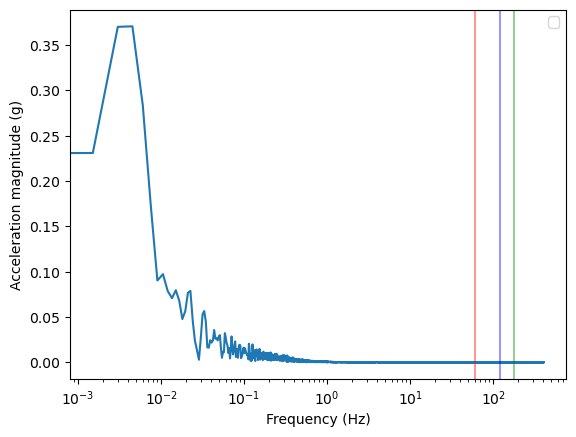

C:\Users\natal\AppData\Local\Temp\ipykernel_40872\3751380795.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


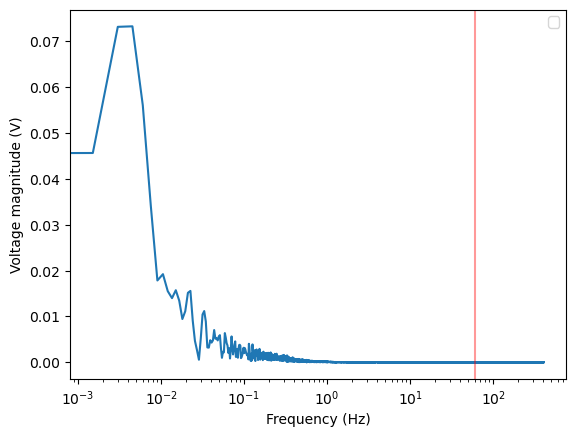

In [288]:
data_ch = data_ch0 #set to any data channel
sampling_rate = 817
N = len(data_ch)
s = np.fft.fft(accel(data_ch) - accel(data_ch.mean())) 
freqs = np.fft.fftfreq(len(data_ch), d=1/sampling_rate)

positive_freqs = freqs[:len(data_ch) // 2]
A_fft = np.abs(s[:len(data_ch) // 2])

# determine the amplitude of the signal in acceleration (g)
A_signal_g = A_fft / (N / 2)

# Plot frequencies
plt.plot(positive_freqs, A_signal_g)
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel("Acceleration magnitude (g)")
plt.xscale('log')
#plt.yscale('log')

plt.axvline(60, c='red', label='60Hz', alpha=0.4)
plt.axvline(120, c='blue', label='120Hz', alpha=0.4)
plt.axvline(180, c='green', label='180Hz', alpha=0.4)
plt.show()

s = np.fft.fft(voltage(data_ch) - voltage(data_ch.mean())) 
freqs = np.fft.fftfreq(len(data_ch), d=1/sampling_rate)

positive_freqs = freqs[:len(data_ch) // 2]
A_fft = np.abs(s[:len(data_ch) // 2])

# determine the amplitude of the signal in voltage
A_signal = A_fft / (N / 2)

# Plot frequencies
plt.plot(positive_freqs, A_signal)
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel("Voltage magnitude (V)")
plt.xscale('log')
#plt.yscale('log')

plt.axvline(60, c='red', label='60Hz', alpha=0.4)
plt.show()

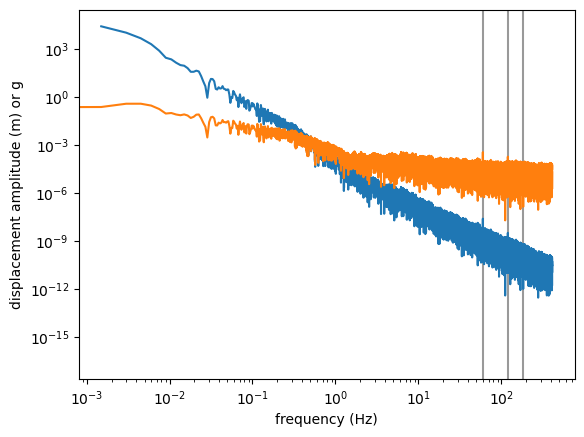

In [289]:
# determine displacement at each amplitude
A_ms2 = A_signal_g * 9.81 #convert g to m/s^2
w = positive_freqs * np.pi * 2
A_displacement = A_ms2[1:] / w[1:]**2
plt.xscale('log')
plt.yscale('log')
plt.ylabel("displacement amplitude (m) or g")
plt.xlabel("frequency (Hz)")
plt.axvline(60, c='k', label='60Hz', alpha=0.4)
plt.axvline(120, c='k', label='120Hz', alpha=0.4)
plt.axvline(180, c='k', label='180Hz', alpha=0.4)
#plt.xlim(1)
plt.plot(positive_freqs[1:], A_displacement)
plt.plot(positive_freqs, A_signal_g)
#plt.ylim(1.e-6,1.e-3)
plt.show()

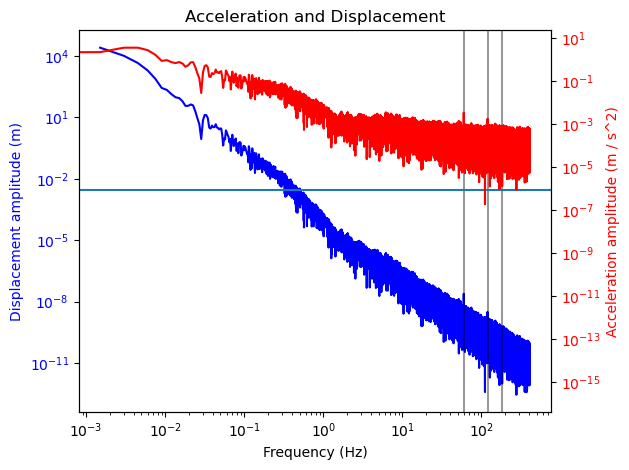

In [290]:
# Assume A_signal_g and positive_freqs are already defined
A_ms2 = A_signal_g * 9.81  # convert g to m/s^2
w = positive_freqs * np.pi * 2
A_displacement = A_ms2[1:] / w[1:]**2

# Create the figure and the first axis (for displacement)
fig, ax1 = plt.subplots()

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel("Frequency (Hz)")
ax1.set_ylabel("Displacement amplitude (m)", color='b')
ax1.plot(positive_freqs[1:], A_displacement, 'b-', label='Displacement')
ax1.tick_params(axis='y', labelcolor='b')

# Add vertical lines on ax1
for f in [60, 120, 180]:
    ax1.axvline(f, c='k', alpha=0.4)

ax1.axhline(0.003)
# Create second y-axis for acceleration in g
ax2 = ax1.twinx()
ax2.set_yscale('log')
ax2.set_ylabel("Acceleration amplitude (m / s^2)", color='r')
ax2.plot(positive_freqs, A_ms2, 'r', label='Acceleration (m / s^2)')
ax2.tick_params(axis='y', labelcolor='r')

plt.title("Acceleration and Displacement")
plt.tight_layout()
plt.show()


In [291]:
def shuyu_fft(data, bin_size, freq):
    """
    data = data
    bin_size = integer number of data points to bin and FFT together
    freq = sampling freq
    """
    
    num_bins = int(len(data)/bin_size)
        
    fft_average = np.zeros(bin_size // 2)
    fft_ = np.zeros((num_bins, bin_size // 2))
    
    fft_freq = np.fft.fftfreq(bin_size, d=1/freq)[:bin_size // 2]
    
    for i in range(num_bins):
        data_bin = data[i*bin_size : (i + 1)*bin_size]
        
        fft_bin = np.fft.fft(data_bin)[:bin_size // 2]
        
        fft_[i] = (2 / bin_size) * np.abs(fft_bin)
        
        fft_average += fft_[i]
    
    fft_average = fft_average / num_bins
    
    return fft_, fft_average, fft_freq, num_bins 

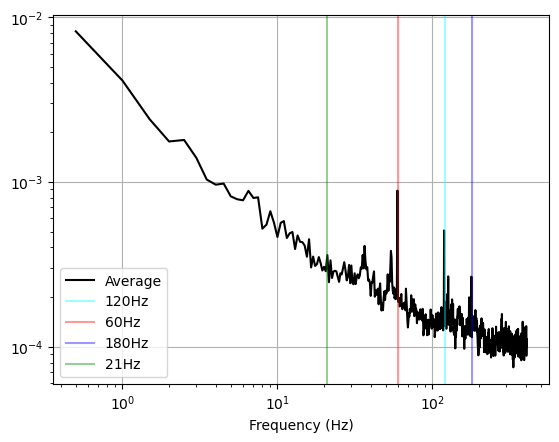

0.008201103127457926


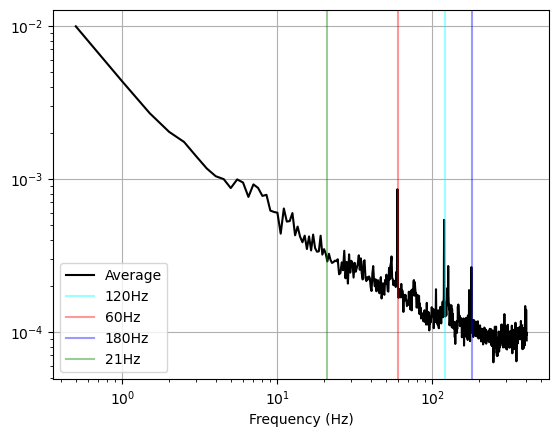

0.009915909579622394


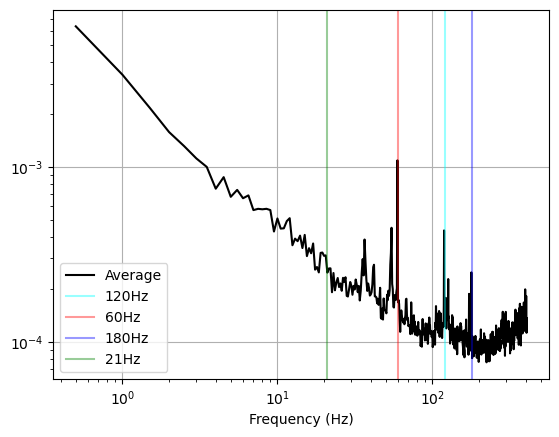

0.006391903563005453


In [292]:
for data_ch in accel(data_ch0), accel(data_ch1), accel(data_ch2):
    fft_ch, fft_average_ch, fft_freq_ch, num_bins_ch = shuyu_fft(data_ch, int(813.35*2), 813.35)
    valid_indices = fft_freq_ch > 0
    plt.plot(fft_freq_ch[valid_indices], abs(fft_average_ch[valid_indices]), color='black', label='Average')
    plt.xlabel('Frequency (Hz)')
    plt.grid()
    #plt.xlim(98,100)
    plt.axvline(120, c='cyan', label='120Hz', alpha=0.4)
    plt.axvline(60, c='red', label='60Hz', alpha=0.4)
    plt.axvline(180, c='blue', label='180Hz', alpha=0.4)
    plt.axvline(21, c='green', label='21Hz', alpha=0.4)
    plt.legend()
    plt.xscale('log')
    plt.yscale('log')
    plt.show()
    print(max(abs(fft_average_ch[valid_indices])))

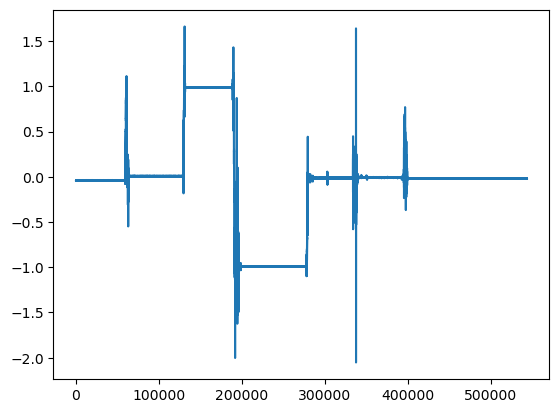

In [293]:
plt.plot(accel(data_ch0))

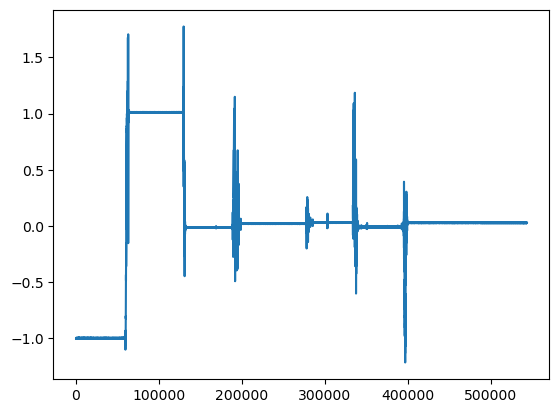

In [294]:
plt.plot(accel(data_ch1))

C:\Users\natal\AppData\Local\Temp\ipykernel_40872\3829151314.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


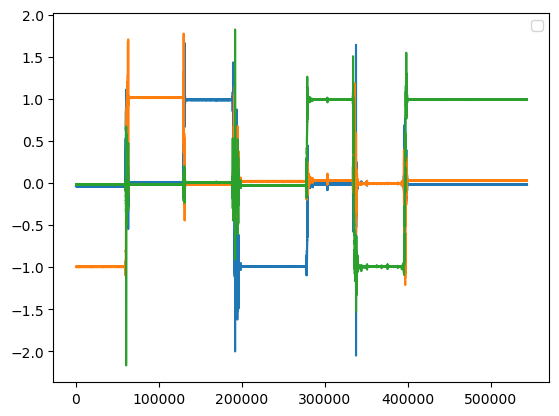

In [295]:
plt.plot(accel(data_ch0))
plt.plot(accel(data_ch1))
plt.plot(accel(data_ch2))
plt.legend()
#plt.ylim(0.9,1.1)

In [296]:
plt

<module 'matplotlib.pyplot' from 'C:\\Users\\natal\\anaconda3\\Lib\\site-packages\\matplotlib\\pyplot.py'>

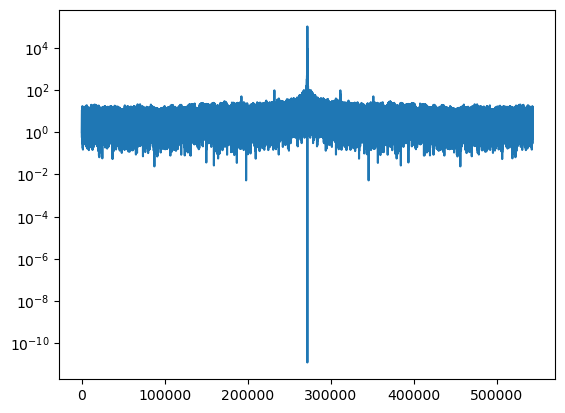

In [297]:
data_ch = data_ch0
fft_accel = np.abs(np.fft.fft(accel(data_ch) - accel(data_ch).mean()))
plt.plot(np.fft.fftshift(fft_accel))
plt.yscale('log')

In [298]:
A_fft = np.max(fft_accel)
N = len(data_ch)
A_sin = A_fft / (N / 2)

# sin wave with amplitude from accelerometer
A_sin_ms2 = A_sin * 9.81 # get amplitude in m/s^2

(353000.0, 393000.0)

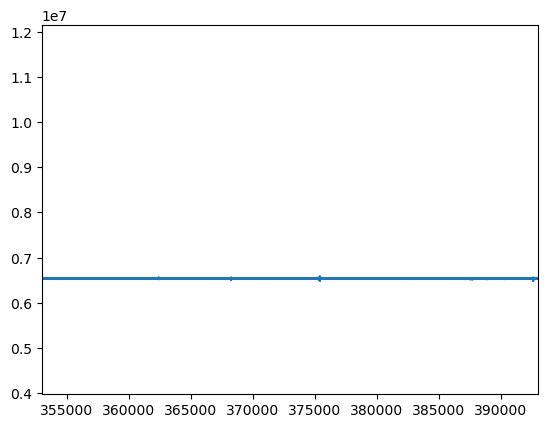

In [299]:
plt.plot(data_ch2)
#plt.ylim(0.8e7, 0.85e7)
plt.xlim(353000, 393000)

In [300]:
#data_ch0
print('data_ch0:')
data_ch0_0g = data_ch0[64000:127000]
data_ch0_0g_avg = np.mean(data_ch0_0g)
print("0g:", data_ch0_0g_avg)

data_ch0_1g = data_ch0[132000:188000]
data_ch0_1g_avg = np.mean(data_ch0_1g)
print("1g:", data_ch0_1g_avg)

data_ch0_neg1g = data_ch0[199000:275000]
data_ch0_neg1g_avg = np.mean(data_ch0_neg1g)
print("-1g:", data_ch0_neg1g_avg)

data_ch0_offset = (data_ch0_1g_avg + data_ch0_neg1g_avg)/2
print("offset:", data_ch0_offset)

raw_disagreement_ch0 = abs(data_ch0_offset - data_ch0_0g_avg)
print("raw disagreement:", raw_disagreement_ch0)

gain_ch0 = (data_ch0_1g_avg - data_ch0_neg1g_avg)/2
print("raw gain (/g):", gain_ch0)

diff_ch0_10 = data_ch0_1g_avg - data_ch0_0g_avg
diff_ch0_0neg1 = data_ch0_0g_avg - data_ch0_neg1g_avg
print("raw difference from 1g to 0g:", diff_ch0_10)
print("raw difference from 0g to -1g:", diff_ch0_0neg1)




data_ch0:
0g: 8403250.179444445
1g: 10226392.524160715
-1g: 6539888.353092105
offset: 8383140.43862641
raw disagreement: 20109.740818034858
raw gain (/g): 1843252.0855343048
raw difference from 1g to 0g: 1823142.3447162695
raw difference from 0g to -1g: 1863361.8263523402


In [301]:
#data_ch1
print('data_ch1:')
data_ch1_0g = np.concatenate((data_ch1[199000:276000],data_ch1[400000:500000])) 
data_ch1_0g_avg = np.mean(data_ch1_0g)
print("0g:", data_ch1_0g_avg)

data_ch1_1g = data_ch1[64000:128000]
data_ch1_1g_avg = np.mean(data_ch1_1g)
print("1g:", data_ch1_1g_avg)

data_ch1_neg1g = data_ch1[5000:58000]
data_ch1_neg1g_avg = np.mean(data_ch1_neg1g)
print("1g:", data_ch1_neg1g_avg)

data_ch1_offset = (data_ch1_1g_avg + data_ch1_neg1g_avg)/2
print("offset:", data_ch1_offset)

raw_disagreement_ch1 = abs(data_ch1_offset - data_ch1_0g_avg)
print("raw disagreement:", raw_disagreement_ch1)

gain_ch1 = (data_ch1_1g_avg - data_ch1_neg1g_avg)/2
print("raw gain (/g):", gain_ch1)

diff_ch1_10 = data_ch1_1g_avg - data_ch1_0g_avg
diff_ch1_0neg1 = data_ch1_0g_avg - data_ch1_neg1g_avg
print("raw difference from 1g to 0g:", diff_ch1_10)
print("raw difference from 0g to -1g:", diff_ch1_0neg1)

data_ch1:
0g: 8434662.99280226
1g: 10273536.338453125
1g: 6528533.463735849
offset: 8401034.901094487
raw disagreement: 33628.09170777351
raw gain (/g): 1872501.4373586383
raw difference from 1g to 0g: 1838873.3456508648
raw difference from 0g to -1g: 1906129.5290664118


In [302]:
#data_ch2
print('data_ch2:')
data_ch2_0g = data_ch2[200000:275000]
data_ch2_0g_avg = np.mean(data_ch2_0g)
print("0g:", data_ch2_0g_avg)

data_ch2_1g = np.concatenate((data_ch2[305000:333000],data_ch2[400000:500000]))
data_ch2_1g_avg = np.mean(data_ch2_1g)
print("1g:", data_ch2_1g_avg)

data_ch2_neg1g = data_ch2[353000: 393000]
data_ch2_neg1g_avg = np.mean(data_ch2_neg1g)
print("-1g:", data_ch2_neg1g_avg)

data_ch2_offset = (data_ch2_1g_avg + data_ch2_neg1g_avg)/2
print("offset:", data_ch2_offset)

raw_disagreement_ch2 = abs(data_ch2_offset - data_ch2_0g_avg)
print("raw disagreement:", raw_disagreement_ch2)

gain_ch2 = (data_ch2_1g_avg - data_ch2_neg1g_avg)/2
print("raw gain (/g):", gain_ch2)

diff_ch2_10 = data_ch2_1g_avg - data_ch2_0g_avg
diff_ch2_0neg1 = data_ch2_0g_avg - data_ch2_neg1g_avg
print("raw difference from 1g to 0g:", diff_ch2_10)
print("raw difference from 0g to -1g:", diff_ch2_0neg1)

data_ch2:
0g: 8335589.216306667
1g: 10231325.921429688
-1g: 6534016.826325
offset: 8382671.373877345
raw disagreement: 47082.15757067781
raw gain (/g): 1848654.547552344
raw difference from 1g to 0g: 1895736.7051230213
raw difference from 0g to -1g: 1801572.3899816666


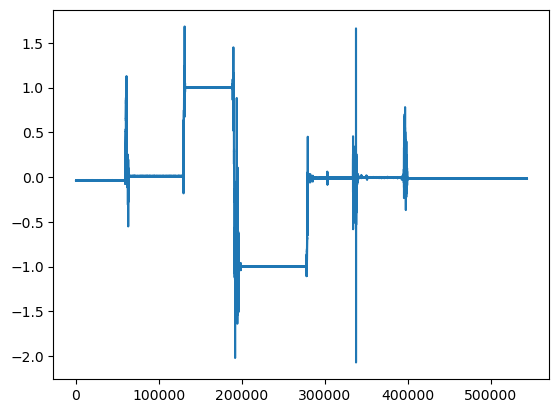

In [303]:
accel_ch0 = (data_ch0 - data_ch0_offset) / gain_ch0
plt.plot(accel_ch0)

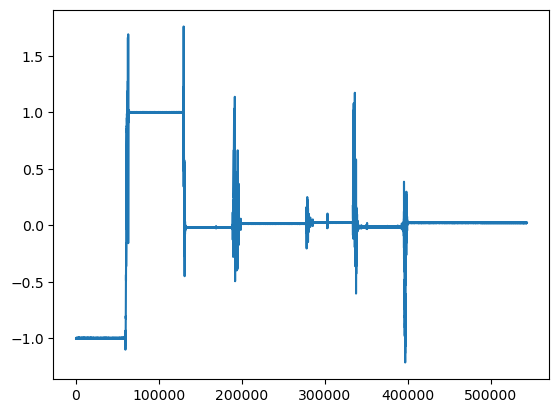

In [304]:
accel_ch1 = (data_ch1 - data_ch1_offset) / gain_ch1
plt.plot(accel_ch1)

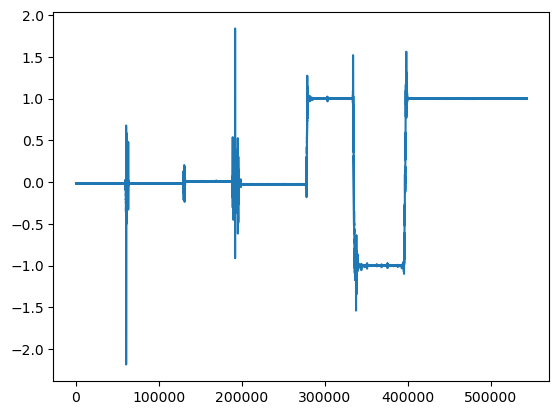

In [305]:
accel_ch2 = (data_ch2 - data_ch2_offset) / gain_ch2
plt.plot(accel_ch2)

1.0007693763028418


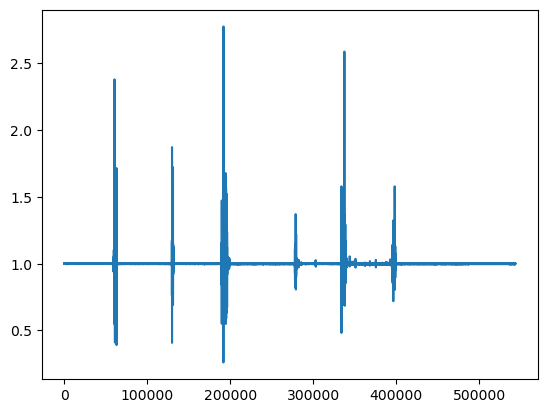

In [306]:
total_accel = np.sqrt(accel_ch0**2 + accel_ch1**2 + accel_ch2**2)
plt.plot(total_accel)
print(np.mean(total_accel[0:1000]))